In [3]:
import pandas as pd
import numpy as np

import scipy.sparse
import sklearn.feature_extraction

import matplotlib.pylab as plt
%matplotlib inline

from tqdm import tqdm
import platform

pd.set_option("display.max_rows", 10)
pd.set_option('display.max_columns', 1100)

import os

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### В матрице Main table всего 3 столбца, которые глобально характеризуют хэдэр

In [2]:
from logParser import ParseLogsFromFolder

main_data, values_data, order_data = ParseLogsFromFolder('Logs/', 10, only_order=False)

main = pd.DataFrame(main_data)
del(main_data)
print('Shape: ' + str(main.shape))
main.head()

  8%|▊         | 10/127 [00:06<01:19,  1.48it/s]


Shape: (289269, 3)


,User_Agent,id,ip
0,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,1485900038,95.181.252.91
1,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1485900047,40.77.167.74
2,Mozilla/5.0 (Linux; Android 4.4.2; Zera S Buil...,1485900079,31.148.3.19
3,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:51.0) G...,1485900103,188.162.183.66
4,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1485900105,37.144.52.103


In [87]:
print('Хэдэры первых 100 юзер-агентов составляют: {:.2%}'.format(
    main.User_Agent.value_counts()[:100].sum() / main.shape[0]))

print('Сохраним индексы хэдэров из топ-100')
main_top_100 = main[main.User_Agent.isin(main.User_Agent.value_counts()[:100].index)]
#del(main)

top_ua = main.User_Agent.value_counts()[:100].index.tolist()

Хэдэры первых 100 юзер-агентов составляют: 62.87%
Сохраним индексы хэдэров из топ-100


In [5]:
print('В order_data содержится информация о взаимном расположении ключей.')
print('Переведем ее к типу csr с помощью DictVectorizer')
orders_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_orders = orders_vectorizer.fit_transform(order_data).astype(np.int8)
del(order_data)
print('Sparse orders: \n{0}'.format(sparse_orders[:1]))
print(type(sparse_orders))

В order_data содержится информация о взаимном расположении ключей.
Переведем ее к типу csr с помощью DictVectorizer
Sparse orders: 
  (0, 0)	3
  (0, 2)	5
  (0, 3)	6
  (0, 48)	4
  (0, 59)	1
  (0, 60)	2
<class 'scipy.sparse.csr.csr_matrix'>


In [6]:
print('Cрез по топ-100 юзер агентам')
sparse_orders_top_100 = sparse_orders[main_top_100.index]
print(sparse_orders_top_100[:1])
sparse_orders_top_100.shape

Cрез по топ-100 юзер агентам
  (0, 0)	3
  (0, 2)	5
  (0, 3)	6
  (0, 48)	4
  (0, 59)	1
  (0, 60)	2


(181851, 174)

Можно было бы сразу создать нужную нам спарс матрицу с признаками попарным сравнением порядков. Однако в этом случае придется думать, как бы запомнить какой признак, что значит.

Так что я решил не думать и сделать по аналогии с вышеприведенным преобразованием: с созданием соответствующего списка словарей и DictVectorizer-a

In [7]:
from itertools import combinations

pairs_dict_list = []
for row_index in tqdm(range(sparse_orders_top_100.shape[0]), mininterval=2):
    pairs_dict = {}
    for pair_first, pair_second in combinations(sparse_orders_top_100[row_index].indices, 2):
        name_first = orders_vectorizer.feature_names_[pair_first]
        name_second = orders_vectorizer.feature_names_[pair_second]
        if sparse_orders_top_100[row_index, pair_first] < sparse_orders_top_100[row_index, pair_second]:
            pairs_dict['{0} < {1}'.format(name_first, name_second)] = 1
        else:
            pairs_dict['{0} < {1}'.format(name_second, name_first)] = 1
    pairs_dict_list.append(pairs_dict)

100%|██████████| 181851/181851 [02:49<00:00, 1075.89it/s]


In [14]:
dummy_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_dummy = dummy_vectorizer.fit_transform(pairs_dict_list).astype(np.int8)
print('Sparse dummy: \n{0}'.format(sparse_dummy[:1]))
print(type(sparse_dummy))
print('Sparse dummy shape: \n{0}'.format(sparse_dummy.shape))
print('User Agent shape: \n{0}'.format(main_top_100.User_Agent.shape))

Sparse dummy: 
  (0, 1)	1
  (0, 2)	1
  (0, 23)	1
  (0, 71)	1
  (0, 535)	1
  (0, 536)	1
  (0, 645)	1
  (0, 646)	1
  (0, 647)	1
  (0, 660)	1
  (0, 663)	1
  (0, 684)	1
  (0, 686)	1
  (0, 687)	1
  (0, 706)	1
<class 'scipy.sparse.csr.csr_matrix'>
Sparse dummy shape: 
(181851, 1042)
User Agent shape: 
(181851,)


## Выбор модели и оценка

* Для получения предсказаний будем использоваться обертку OneVsRestClassifier над следующими классификаторами:
- Ridge, Lasso
- LogisticRegression
- RandomForest
- XGBoost
- SVM

In [179]:
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

#y = main_top_100.User_Agent

lb = preprocessing.LabelBinarizer()
lb.fit(top_ua)
y = lb.transform(main_top_100.User_Agent)

#binarizer = MultiLabelBinarizer()
#y = binarizer.fit_transform(main_top_100.User_Agent.apply(lambda x: code_ua(x)))
#y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sparse_dummy, y, test_size=0.33, random_state=42)

### Логистическая регрессия с hold-out валидацией

In [107]:
%%time
clf = OneVsRestClassifier(LogisticRegression(random_state=42)) #OneVsRestClassifier by default
clf.fit(X_train, y_train)
answer = clf.predict(X_test)
print(clf)
print(answer)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
CPU times: user 2min 13s, sys: 260 ms, total: 2min 13s
Wall time: 2min 15s


In [108]:
clf.multilabel_

True

In [109]:
from sklearn.metrics import accuracy_score

print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=answer, average='samples')))

Accuracy score 0.5613470863674993
F1 score 0.5616470313775808


/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


### Ненастроенный baseline дал 64% качества?

## 56% на мультилейблинге (что ожидаемо)

In [163]:
def return_ua(index):
    return top_ua[index]

In [164]:
def return_prediction_ua(list):
    ua_list = []
    for i, label in enumerate(list):
        if label == 1:
            ua_list.append(return_ua(i))
    return ua_list

In [170]:
y_test_names = pd.DataFrame(y_test).apply(lambda l: return_prediction_ua(l), axis=1)
y_predicted = pd.DataFrame(answer).apply(lambda l: return_prediction_ua(l), axis=1)

compare_answers = []
for i, y_tst in enumerate(y_test_names):
    current_answer = True
    for j, tst_val in enumerate(y_tst):
        if tst_val not in y_predicted[i]:
            current_answer = False
    compare_answers.append(current_answer)

pd.concat([pd.DataFrame(y_test_names), pd.DataFrame(y_predicted), pd.DataFrame(compare_answers)], axis=1)

,0,0,0
0,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,[Mozilla/5.0 (Windows NT 6.3; Win64; x64) Appl...,True
1,[netEstate NE Crawler (+http://www.website-dat...,[],False
2,[Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 lik...,[],False
3,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,[Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http...,True
4,[Mozilla/5.0 (compatible; Yahoo! Slurp; http:/...,[],False
...,...,...,...
60006,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,[Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....,True
60007,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True
60008,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,[Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...,True
60009,[Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS ...,[Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS ...,True


### Пространство для маневра:
  
- подбор параметров логистической регрессии
- работать с вероятностями
- аккуратный выбор порога классификации
- tf-idf
- хорошая метрика мультиклассификации
- другая модель классификации
- кластеризация юзер-агентов

Также как видно на вышеприведенном примере, некоторые метки юзер агента несут схожую смысловую и как видимо логическую нагрузку, стало быть ошибка между такими юзер-агентами не так уж и важна. Для отработки таких кейсов имеет смысл провести предварительную кластеризацию юзер агентов. Например, хороших результатов может уже дать k-means, ведь объектов у нас много, обычная близость в эвклидовом пространстве вышевыведенных признаков может уже очень многое дать.
Ну или обощенная гауссова модель.

### Оценим качество вышеприведенной модели на кросс-валидации по точности

In [112]:
%%time

clf = OneVsRestClassifier(LogisticRegression())
#cv_report = cross_val_score(
#    X=sparse_dummy, y=y, estimator=clf, 
#    cv=5, n_jobs=-1, scoring='accuracy')
cv_report = cross_val_score(
    X=sparse_dummy, y=y, estimator=clf, 
    cv=5, n_jobs=-1, scoring='f1_samples')
print(cv_report)

/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 68 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.


[ 0.55756418  0.60726331  0.47132893  0.50741454  0.58485473]
CPU times: user 2.05 s, sys: 332 ms, total: 2.38 s
Wall time: 7min 10s


Печальные ошибки сопровождают. Надо бы потыкать

https://stackoverflow.com/questions/42821315/userwarning-label-not-number-is-present-in-all-training-examples

### Настроим коэффициент регуляризации в логистической регрессии на точность 

Настраивать будем на кросс-валидации по 5 фолдам

In [113]:
%%time

params = {'estimator__C': np.logspace(-5, 5, 11)}

model = OneVsRestClassifier(LogisticRegression())
gs = GridSearchCV(model, params, n_jobs=-1, scoring='f1_samples', cv=5)
gs.fit(sparse_dummy, y)
print(gs.best_params_)
print(gs.best_score_)

/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 68 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.


/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 68 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarnin

/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


{'estimator__C': 100.0}
0.549494575753
CPU times: user 6min 27s, sys: 1.59 s, total: 6min 29s
Wall time: 1h 33min 39s


In [114]:
pd.DataFrame(gs.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
7,0.549495,{'estimator__C': 100.0}
10,0.549242,{'estimator__C': 100000.0}
8,0.549190,{'estimator__C': 1000.0}
9,0.549149,{'estimator__C': 10000.0}
6,0.548842,{'estimator__C': 10.0}
...,...,...
4,0.534970,{'estimator__C': 0.1}
3,0.500140,{'estimator__C': 0.01}
2,0.332464,{'estimator__C': 0.001}
1,0.215088,{'estimator__C': 0.0001}


Результаты печальные, что в общем-то ожидаемо, ведь эти модели не так уж хороши на столь разреженных пространствах
Подбор параметров по сетке в принципе мог бы и улучшить результат, однако в целом порядок понятен

### Попробуем NaiveBayes

In [172]:
%%time
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
nb_clf.fit(X_train, y_train)
nb_answer = nb_clf.predict(X_test)
print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=nb_answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=nb_answer, average='samples')))

Accuracy score 0.26031894152738666
F1 score 0.4965621141397161
CPU times: user 3.48 s, sys: 284 ms, total: 3.76 s
Wall time: 4.65 s


/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


**Результат не самый лучший, зато вычисления ну очень быстрые**

**Да норм результат, всего на 4% ниже как на такую скорость (Олег)**

## Tf-Idf

Значение Tf-Idf для каждого пары документ-слово состоит из двух компонент:
* Term frequency — логарифм встречаемости слова в документе
$$tf(t, d) = \log n_{t,d}$$

* Inverse Document frequency — логарифм обратной доли документов в которых встретилось данное слово
$$idf(t, D) = \log \frac{ \mid D \mid}{\mid \{ d_i \in D \mid t \in d_i \} \mid}$$

* Tf-Idf — кобминация tf и idf
$$ TfIdf(t, d, D) = tf(t, d) * idf(t, D)$$

In [173]:
tf_idf_vectorizer = sklearn.feature_extraction.text.TfidfTransformer()
tf_idf = tf_idf_vectorizer.fit_transform(sparse_dummy)
print(tf_idf.shape)
print(type(tf_idf))
print(sparse_dummy[:1])
print(tf_idf[:1])

(181851, 1042)
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 1)	1
  (0, 2)	1
  (0, 23)	1
  (0, 71)	1
  (0, 535)	1
  (0, 536)	1
  (0, 645)	1
  (0, 646)	1
  (0, 647)	1
  (0, 660)	1
  (0, 663)	1
  (0, 684)	1
  (0, 686)	1
  (0, 687)	1
  (0, 706)	1
  (0, 706)	0.27615587655
  (0, 687)	0.243136142345
  (0, 686)	0.220008834592
  (0, 684)	0.264015084982
  (0, 663)	0.277554936539
  (0, 660)	0.286043115875
  (0, 647)	0.277650955254
  (0, 646)	0.281143440928
  (0, 645)	0.286671249375
  (0, 536)	0.277057295913
  (0, 535)	0.267453235376
  (0, 71)	0.218371154508
  (0, 23)	0.252327164808
  (0, 2)	0.228119132158
  (0, 1)	0.194062155613


** Логистическая регрессия по tf-idf**

In [174]:
%%time
X_train, X_test, y_train, y_test = train_test_split(tf_idf, y, test_size=0.33, random_state=42)
tf_clf = OneVsRestClassifier(LogisticRegression(random_state=42), n_jobs=-1)
tf_clf.fit(X_train, y_train)
tf_answer = tf_clf.predict(X_test)
print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=tf_answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=tf_answer, average='samples')))

Accuracy score 0.5541983969605573
F1 score 0.5542095060350046
CPU times: user 4.95 s, sys: 272 ms, total: 5.22 s
Wall time: 35.6 s


/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


**Наивный Байес по tf-idf**

In [50]:
%%time
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
nb_clf.fit(X_train, y_train)
nb_tf_answer = nb_clf.predict(X_test)
print("Accuracy score {0}".format(accuracy_score(y_true=y_test, y_pred=nb_tf_answer)))
print("F1 score {0}".format(f1_score(y_true=y_test, y_pred=nb_tf_answer, average='samples')))

Accuracy score 0.6090550065821266
F1 score 0.5414337198836546
CPU times: user 6.86 s, sys: 212 ms, total: 7.07 s
Wall time: 7.79 s


/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Переход к новой парадигме многоклассовой многолейблинговой классификации

Как видим лучше не стало. Однако закапывать tf/idf не стоит - ведь так произошло лишь в текущей постановке задачи.

Я веду к тому, что так произошло при решении задачи о многоклассовой классификации хэдэров на юзер-агенты.
Решая данную задачу, неявно мы предпологаем, что каждый хэдэр принадлежит ровно одному юзер-агенту, а несовпадение фактического и предсказанного классов говорит о том, что данный хэдэр является ботом. Ввиду строгости этого правила, ошибка первого рода становится очень большой, что недопустимо с точки зрения бизнеса.

Решить эту проблему можно, если разрешить хэдэрам принадлежать сразу нескольким классам. Целевая переменная в этом случае у нас будет не просто юзер агентом, а некоторым вектором принадлежности определенного хэдэра ко всем юзер-агентом. В частности, в нашем случае этот вектор будет размерности (1, 100), а на всех тренировочных объектах у нас будет ровно одна единица и 99 нулей.

В такой постановке задачи, наши модели должны выдавать некоторый вектор вероятностей принадлежности объекта к определенному классу, затем для окончательного ответа нужно подобрать некоторые пороги для каждого элемента вектора.

И уже на такой задаче, TF-IDF, судя по аналогичным задачам из анализа текстов, сыграет намного более лучшим образом, чем просто порядковые признаки.

In [175]:
params = {'estimator__C': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(LogisticRegression())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(X_train, y_train);

/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/p

/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/levabd/anaconda3/lib/p

In [176]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
10,0.566710,{'estimator__C': 100000.0}
9,0.566684,{'estimator__C': 10000.0}
8,0.566622,{'estimator__C': 1000.0}
7,0.566140,{'estimator__C': 100.0}
6,0.563042,{'estimator__C': 10.0}
...,...,...
4,0.530827,{'estimator__C': 0.1}
3,0.413846,{'estimator__C': 0.01}
2,0.010292,{'estimator__C': 0.001}
0,0.000000,{'estimator__C': 1e-05}


## Выбор порога

* При вызове ```predict``` возвращается 1, если вероятность принадлежности к классу больше $0.5$
* Можно выбирать порог самому через кросс-валидацию

In [180]:
clf = OneVsRestClassifier(LogisticRegression(C=100000))
%time y_hat_dummy = cross_val_predict(clf, sparse_dummy, y, method='predict_proba')
%time y_hat_tf_idf = cross_val_predict(tf_clf, tf_idf, y, method='predict_proba')

/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 78 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 68 is present in all training examples.
  str(classes[c]))


CPU times: user 25min 1s, sys: 836 ms, total: 25min 2s
Wall time: 25min 8s


/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 78 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))
/home/levabd/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 68 is present in all training examples.
  str(classes[c]))


CPU times: user 13.7 s, sys: 1.2 s, total: 14.9 s
Wall time: 1min 40s


In [182]:
def get_score(alpha, y, y_hat):
    return f1_score(y, (y_hat > alpha).astype('int'), average='samples')

## Выбор порога для Dummy

* Качество с порогом по умолчанию — $F1=0.54$
* Качество с подобранным порогом — $F1=0.56$

In [187]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

from matplotlib.pyplot import *

0.618941875955
0.0848484848485


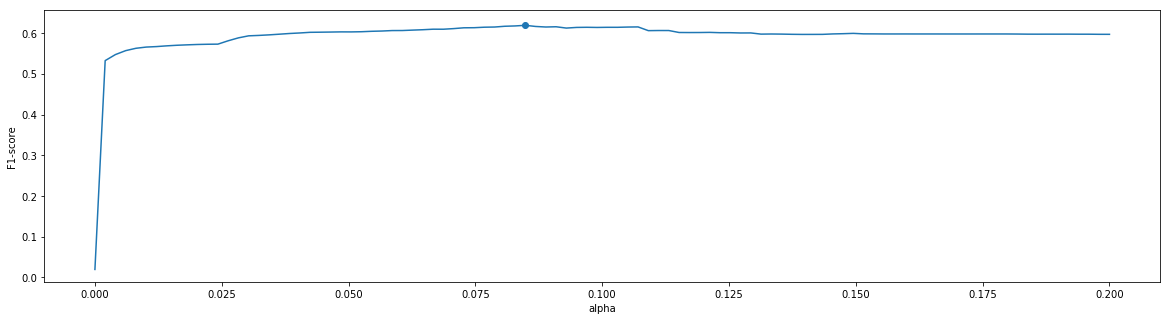

In [191]:
alphas = np.linspace(0.0, 0.2, 100)
scores = [get_score(alpha, y, y_hat_dummy) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
ylabel('F1-score')
xlabel('alpha')


print(np.max(scores))
print(alphas[np.argmax(scores)])

## Выбор порога для Tf-Idf

* Качество с порогом по умолчанию — $F1=0.55$
* Качество с подобранным порогом — $F1=0.52$

0.617479197386
0.0848484848485


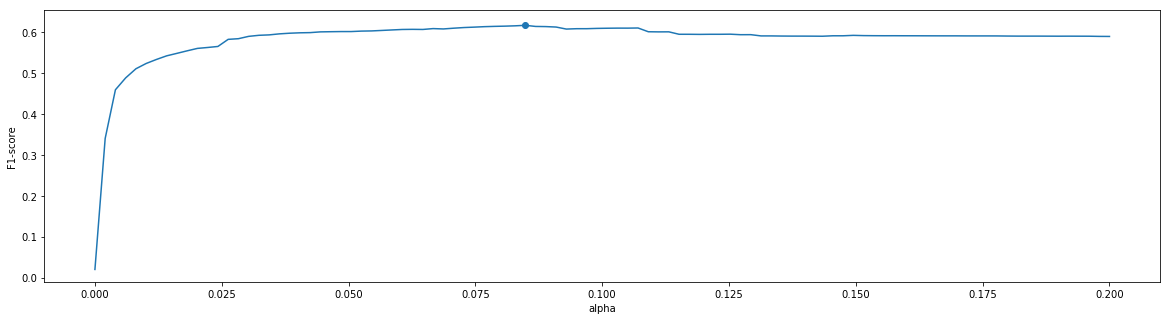

In [190]:
alphas = np.linspace(0.0, 0.2, 100)
scores = [get_score(alpha, y, y_hat_tf_idf) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
ylabel('F1-score')
xlabel('alpha')

print(np.max(scores))
print(alphas[np.argmax(scores)])

### Добавим значения ключей в модель

**Согласно README удалим неинформативные ключи**

In [192]:
exception_keys_set = {
    'User-Agent', 'Referer', 'Accept-Language', 'Host', 'X-Host','X-Forwarded-For',
    'Forwarded-For' ,'X-Network-Type','Cookie','X-Wap-Profile','X-Gateway','Ua-Cpu',
    'Rvbd-Csh','Dris-Orig-Src','X-Proxy-Id','Rvbd-Ssh','X-Requested-With'}

In [193]:
for row_index in tqdm(range(len(values_data))):
    for key in exception_keys_set:
        values_data[row_index].pop(key, -1)

100%|██████████| 289269/289269 [00:01<00:00, 196908.19it/s]


In [194]:
values_data[:3]

[{'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
  'Accept-Encoding': 'gzip, deflate, sdch',
  'Connection': 'keep-alive',
  'Upgrade-Insecure-Requests': '1'},
 {'Accept': '*/*',
  'Accept-Encoding': 'gzip, deflate',
  'Cache-Control': 'no-cache',
  'Connection': 'Keep-Alive',
  'From': 'bingbot(at)microsoft.com',
  'Pragma': 'no-cache'},
 {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
  'Accept-Encoding': 'gzip, deflate, sdch',
  'Connection': 'keep-alive',
  'Upgrade-Insecure-Requests': '1'}]

In [195]:
values_df = pd.DataFrame(values_data)
values_df.head()

,Accept,Accept-Charset,Accept-Encoding,Authorization,Cache-Control,Cdn-Src-Ip,Charset,Chrome-Proxy,Chrome-Proxy-Accept-Transform,Client-Ip,Clientip,Cmd,Connection,Content-Length,Content-Range,Content-Type,Cookie2,Date,Device-Stock-Ua,Dnt,Drm-Version,F5-User-Ip,Forwarded,From,Giga-Transport,Http-Version,Http2-Settings,Https,If-Modified-Since,If-None-Match,Inter-Pro-Client,Keep-Alive,O2gw-Id,Origin,Oxpry-Connection,Ping-From,Ping-To,Pragma,Prefer,Proxy-Authorization,Proxy-Connection,Purpose,Q-Refer,Q-Ua,Range,Refresh-Cache,Rmch-Securitycookie,Save-Data,Scheme,Surrogate-Capability,Te,Upgrade,Upgrade-Insecure-Requests,Useragent,Version,Via,Wap-Connection,Wapconnection,Wshost,Wsip,X--------------,X-Accept-Encoding-Wn-Proxy-2,X-Agent-Client-Id,X-Agent-Session-Id,X-Att-Deviceid,X-Authenticated-User,X-B3-Flags,X-B3-Parentspanid,X-B3-Sampled,X-B3-Spanid,X-B3-Traceid,X-Bluecoat-Via,X-Busid,X-Categories,X-Chrome-Connected,X-Chrome-Uma-Enabled,X-Citrio-Timestamp,X-Client-Data,X-Cloud-Trace-Context,X-Compress,X-Content-Check,X-Content-Opt,X-D-Forwarder,X-Ebo-Ua,X-Fb-Http-Engine,X-Fb-Net-Hni,X-Fb-Sim-Hni,X-Featureversion,X-Firephp,X-Firephp-Version,X-Forwarded-Proto,X-Fuck,X-Getzip,X-Gfe-Ssl,X-Gfe-Tls-Channelid,X-Icap-Http-Stream,X-Icm,X-Imforwards,X-Iws-Via,X-Lb-Local,X-Liveinternetapplications,X-Loop-Control,X-Mcproxyfilter,X-Mfe-Response,X-Miorigin,X-Moz,X-Ms-Cookieuri-Requested,X-Msisdn,X-Mwg-Via,X-Newrelic-Id,X-Newrelic-Transaction,X-Nokia-Bearer,X-Nokia-Gateway-Id,X-Nokia-Maxdownlinkbitrate,X-Nokia-Maxuplinkbitrate,X-Nokia-Musicshop-Bearer,X-Nokia-Musicshop-Version,X-Ob,X-Office-Major-Version,X-Onv-Icap,X-Openfrequencylimit,X-Openshield,X-Opera-Id,X-Opera-Info,X-Operamini-Fb,X-Operamini-Features,X-Operamini-Phone,X-Operamini-Phone-Ua,X-Operamini-Route,X-Org-Request,X-Original-Url,X-P2p-Peerdist,X-P2p-Peerdistex,X-Pocket-Parser,X-Ps3-Browser,X-Psa-Client-Features,X-Psa-Client-Options,X-Psp-Browser,X-Psp-Productcode,X-Puffin-Ua,X-Purpose,X-Rbt-Optimized-By,X-Real-Ip,X-Requestfrom,X-Server-Ip,X-Time,X-Turbo-Compression,X-Turbo-Id,X-Ucbrowser-Device,X-Ucbrowser-Device-Ua,X-Ucbrowser-Ua,X-Up-Vfza-Id,X-User,X-Vermeer-Content-Type,X-Wap-Client-Ip,X-Wap-Profile-Diff,X-Wap-Proxy-Cookie,X-Wapipaddr,X-Wf-Max-Combined-Size,X-Wisp,X-Xorwarded-For,X-Xuthenticated-User,X-Yandex-Turbo,X-Youtube-Edu-Filter,X3,Xroxy-Connection
0,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,*/*,NaN,"gzip, deflate",NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep-Alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bingbot(at)microsoft.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [196]:
print(values_df.shape)
for column in values_df.columns:
    print(column, values_df[column].unique().shape, values_df[column].dropna().shape)

(289269, 166)
Accept (255,) (275910,)
Accept-Charset (66,) (21277,)
Accept-Encoding (43,) (271181,)
Authorization (3,) (9,)
Cache-Control (76,) (27250,)
Cdn-Src-Ip (2,) (1,)
Charset (2,) (3,)
Chrome-Proxy (10,) (12,)
Chrome-Proxy-Accept-Transform (2,) (4,)
Client-Ip (8,) (9,)
Clientip (724,) (856,)
Cmd (43,) (42,)
Connection (15,) (233711,)
Content-Length (638,) (1587,)
Content-Range (2,) (12,)
Content-Type (15,) (2702,)
Cookie2 (4,) (22,)
Date (9,) (8,)
Device-Stock-Ua (579,) (1208,)
Dnt (3,) (16536,)
Drm-Version (4,) (9,)
F5-User-Ip (14,) (15,)
Forwarded (6248,) (7682,)
From (18,) (37298,)
Giga-Transport (50,) (49,)
Http-Version (2,) (2,)
Http2-Settings (2,) (2,)
Https (2,) (19,)
If-Modified-Since (10880,) (11255,)
If-None-Match (4,) (21,)
Inter-Pro-Client (3,) (8,)
Keep-Alive (6,) (836,)
O2gw-Id (4,) (3,)
Origin (8,) (176,)
Oxpry-Connection (2,) (3,)
Ping-From (45,) (46,)
Ping-To (37,) (46,)
Pragma (2,) (22310,)
Prefer (2,) (50,)
Proxy-Authorization (222,) (336,)
Proxy-Connection (5

Применим очень тупой отбор признаков:
- если определенный ключ появляется ну очень редко(например менее чем в 0.1% хэдэров, то мы считаем его неинформативным)
- если у определенного ключа почти все значения различны(например если отношение общего значений к числу уникальных очень мало(например меньше 2)

In [197]:
print(values_df.shape)
important_keys = []
for column in values_df.columns:
    not_null_count = values_df[column].dropna().shape[0]
    if not_null_count  >= values_df.shape[0] * 0.001:
        uniq_count = values_df[column].unique().shape[0]
        if not_null_count / uniq_count >= 2:
            print(column, uniq_count, not_null_count)
            important_keys.append(column)
' '.join(important_keys)

(289269, 166)
Accept 255 275910
Accept-Charset 66 21277
Accept-Encoding 43 271181
Cache-Control 76 27250
Connection 15 233711
Content-Length 638 1587
Content-Type 15 2702
Device-Stock-Ua 579 1208
Dnt 3 16536
From 18 37298
Keep-Alive 6 836
Pragma 2 22310
Proxy-Connection 5 346
Range 10 483
Save-Data 3 8824
Scheme 2 4849
Surrogate-Capability 74 317
Te 4 892
Upgrade-Insecure-Requests 2 111716
Via 1590 11229
X-Compress 5 1337
X-Forwarded-Proto 2 1395
X-Moz 2 1982
X-Operamini-Features 16 1317
X-Operamini-Phone 37 1317
X-Operamini-Phone-Ua 575 1309
X-Turbo-Compression 2 332
X-Yandex-Turbo 3 1434


'Accept Accept-Charset Accept-Encoding Cache-Control Connection Content-Length Content-Type Device-Stock-Ua Dnt From Keep-Alive Pragma Proxy-Connection Range Save-Data Scheme Surrogate-Capability Te Upgrade-Insecure-Requests Via X-Compress X-Forwarded-Proto X-Moz X-Operamini-Features X-Operamini-Phone X-Operamini-Phone-Ua X-Turbo-Compression X-Yandex-Turbo'

In [198]:
values_df = values_df[important_keys]
values_df.head()

,Accept,Accept-Charset,Accept-Encoding,Cache-Control,Connection,Content-Length,Content-Type,Device-Stock-Ua,Dnt,From,Keep-Alive,Pragma,Proxy-Connection,Range,Save-Data,Scheme,Surrogate-Capability,Te,Upgrade-Insecure-Requests,Via,X-Compress,X-Forwarded-Proto,X-Moz,X-Operamini-Features,X-Operamini-Phone,X-Operamini-Phone-Ua,X-Turbo-Compression,X-Yandex-Turbo
0,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,*/*,NaN,"gzip, deflate",no-cache,Keep-Alive,NaN,NaN,NaN,NaN,bingbot(at)microsoft.com,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,*/*,NaN,"gzip, deflate",NaN,close,NaN,NaN,NaN,NaN,NaN,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sparse_dummy_values = pd.get_dummies(values_df).to_sparse()

In [ ]:
sparse_dummy_values

- sparse_dummy - наивные начальные данные без TF-IDF
- tf_idf = tf_idf_vectorizer.fit_transform(sparse_dummy)   _Внезапная внезапность_
- sparse_dummy_values - значения